[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%208%20-%20RNNs/P8_RNNs.ipynb)

# Text generation with an RNN

In this notebook we will learn how to generate text with a Recurrent Neural Network.

We will work with a dataset of Shakespeare's writing from Andrej Karpathy's article [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

Given a sequence of characters from this data (for example "Shakespear"), we will train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

### Import the necessary modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  2.0.0+cu118


In [ ]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Download the Shakespeare dataset

In [ ]:
! wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

--2023-05-01 09:37:40--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt.1’

shakespeare.txt.1   100%[===================>]   1.06M  --.-KB/s    in 0.009s  

2023-05-01 09:37:40 (120 MB/s) - ‘shakespeare.txt.1’ saved [1115394/1115394]



###  Create a dataset class

For training we need a dataset of (input, label) pairs. Where input and label are sequences of characters. At each time step the input is the current character and the label is the next character. For example:

```
input = ['S', 'h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r']
label = ['h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r', 'e']
 ```

Actually we will vectorize the characters to convert them into numerical values.

```
input = [44, 7, 0, 10, 4, 18, 15, 4, 0, 17]
label = [7, 0, 10, 4, 18, 15, 4, 0, 17, 4]
```

where each integer value is a class label, and the number of classes is the number of unique characters in our training data (our vocabulary size).

In [ ]:
class DatasetFromTextFile():
    def __init__(self, filename, sequence_length):
        self.filename = filename
        self.sequence_length = sequence_length

        # The whole sequence of characters in the text file (including characters like the end of line character '\n', punctuation marks, etc.)
        self.chars = self.load_chars()
        # The list of unique characters (our vocabulary)
        self.uniq_chars = self.get_uniq_chars()

        # A dictionary with indices as keys and characters as values
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        # A dictionary with characters as keys and indices as values
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        # The whole sequence of character indexes
        # We want to vectorize our text using one-hot vectors at character level
        # But instead of using the one-hot vector we just keep the index of the 1 value
        self.chars_indices = [self.char_to_index[w] for w in self.chars]

        # Split the sequence into chunks of `sequence_length` characters
        # `x` is the input to the model and `y` is the output of the model
        # `y` is the same seuqence as `x` but one character shifted to the right.
        self.x, self.y = self.get_data()

    def load_chars(self):
        with open(self.filename) as fp:
            text = fp.read()
        print(f'Length of text: {len(text)} characters')
        return text

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indices)-self.sequence_length, self.sequence_length):
            x.append(np.array(self.chars_indices[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indices[index+1:index+self.sequence_length+1]))

        return  torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y)).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        assert ((idx >= 0) & (idx < len(self.y))), "Dataset index out of range"
        return self.x[idx], self.y[idx]

Now we can use the [`torch.utils.data.TensorDataset`](https://pytorch.org/docs/stable/data.html) and [`torch.utils.data.Dataloader`](https://pytorch.org/docs/stable/data.html) classes to create the PyTorch dataloader. Notice that the `TensorDataset` class allows us to easily create a PyTorch `Dataset` from numpy arrays `(inputs, labels)`.

In [ ]:
# Create the dataset
sequence_length = 100
ShakespeareDataset = DatasetFromTextFile('shakespeare.txt', sequence_length)

print(f'We have {ShakespeareDataset.x.shape[0]} input sequence samples of length {ShakespeareDataset.x.shape[1]} \
and {ShakespeareDataset.y.shape[0]} label sequences of length {ShakespeareDataset.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_loader = DataLoader(ShakespeareDataset, shuffle=True, batch_size=batch_size, drop_last=True)

Length of text: 1115394 characters
Unique characters (vocabulary size): 65
We have 11153 input sequence samples of length 100 and 11153 label sequences of length 100


## Build the model

Our model has three layers:

* `torch.nn.Embedding`: The input layer. A trainable lookup table that will map each character-ID (class ID) to a dense vector with `embedding_dim` dimensions;
* `torch.nn.GRU`: A type of RNN with `hidden_dim` units
* `torch.nn.Linear`: The output layer, with number of outputs as our vocabulary size (`len(dataset.uniq_chars)`). It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.


For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

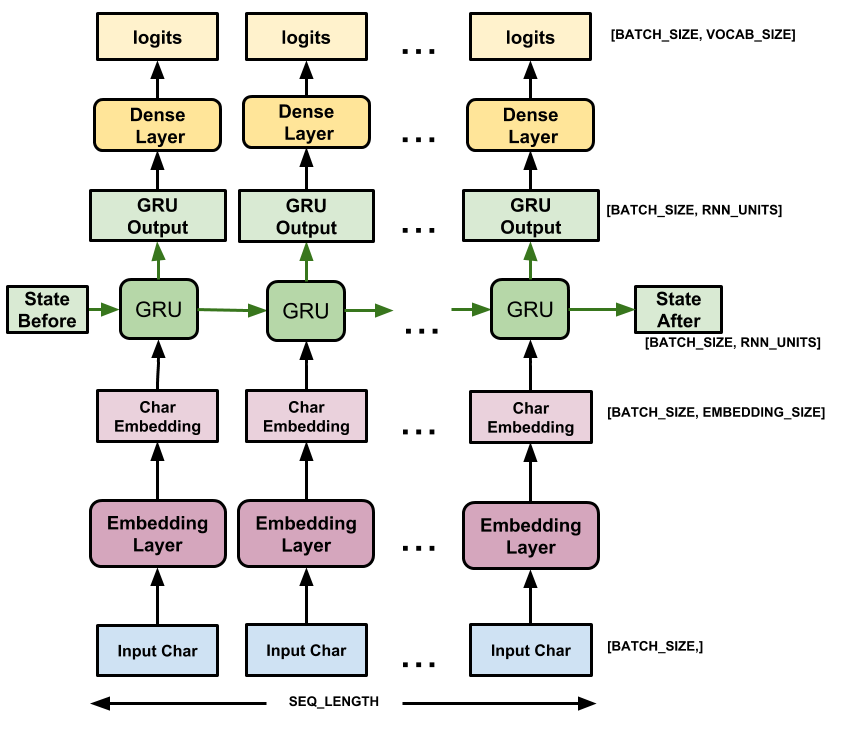

Image source: http://www.tensorflow.org

<span style="color:blue">
    
**Exercise 1:** Complete the code of the `Model` class. You need to embed your input using an `nn.Embedding` layer, create a GRU with `n_layers`, and then compute the output logits.
    
</span>

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_dim,embedding_dim = embedding_dim)
        self.gru = nn.GRU(input_size = embedding_dim,num_layers = n_layers,hidden_size = hidden_dim,dropout = drop_prob, batch_first = True)
        self.fc = nn.Linear(in_features = hidden_dim, out_features = output_dim)


    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.gru(emb, h)
        out = self.fc(out)
        return out, h

    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

Now we can instantiate the model as follows:

In [ ]:
input_dim = len(ShakespeareDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(ShakespeareDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

model = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model)

Model(
  (embedding): Embedding(65, 300)
  (gru): GRU(300, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


## Quick Experiment

Let's create a string and pass it through our model

In [ ]:
data = torch.tensor([ShakespeareDataset.char_to_index[w] for w in "Hello"])
print(data.shape)

torch.Size([5])


Our model expects a batch. We will create a batch of 1, using this one data point we have created

In [ ]:
data = data.unsqueeze(0) # this adds one more dimension (the batch one) to our data
print(data.shape)

torch.Size([1, 5])


Time to pass this through our model. To do so, we need to (1) move our data to the same device like the model and (2) initialise the state of our RNN

In [ ]:
data = data.to(device)
state = model.init_hidden(batch_size = 1) # remember that we will use just a single data point here
state = state.to(device)
out, state = model(data, state) # The forward pass expects the current state as an argument, and returns the updated state in the output

print(out.shape)

torch.Size([1, 5, 65])


Our output returns 65 probability values for each character... We need to find which one is the maximum probability for each position, and convert it to the corresponding character

In [ ]:
_, idxs = torch.max(out[0], dim = 1)

print([ShakespeareDataset.index_to_char[int(c)] for c in idxs])

['O', '3', 'v', 'v', 'O']


As expected both inputs and outputs have the same shape, and the predicted characters are just random since the model is not trained yet.

## Train the model

Training a language model is essentially a classification problem. Given the previous RNN state, and the input character at this time step, predict the class of the next character.

<span style="color:blue">

**Exercise 2:** which loss function do you think we shall use to train our model?
    
</span>

In [ ]:
def train(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion =  nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):

        for batch, (x, y) in enumerate(dataloader):
            state = model.init_hidden(batch_size) # Start with a new state in each batch
            state = state.to(device)

            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            y_pred, state = model(x, state)
            loss = criterion(y_pred.transpose(1, 2), y)

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
    return losses

Now train the model for 20 epochs and visualize the training loss curve.

In [ ]:
num_epochs = 20

losses = train(train_loader, model, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.17770528793335}
{'epoch': 0, 'batch': 30, 'loss': 2.2153971195220947}
{'epoch': 0, 'batch': 60, 'loss': 1.9687751531600952}
{'epoch': 0, 'batch': 90, 'loss': 1.8208881616592407}
{'epoch': 0, 'batch': 120, 'loss': 1.6795161962509155}
{'epoch': 0, 'batch': 150, 'loss': 1.5941585302352905}
{'epoch': 1, 'batch': 0, 'loss': 1.569591999053955}
{'epoch': 1, 'batch': 30, 'loss': 1.5246822834014893}
{'epoch': 1, 'batch': 60, 'loss': 1.4546176195144653}
{'epoch': 1, 'batch': 90, 'loss': 1.4959852695465088}
{'epoch': 1, 'batch': 120, 'loss': 1.4705259799957275}
{'epoch': 1, 'batch': 150, 'loss': 1.446784257888794}
{'epoch': 2, 'batch': 0, 'loss': 1.3342820405960083}
{'epoch': 2, 'batch': 30, 'loss': 1.3752355575561523}
{'epoch': 2, 'batch': 60, 'loss': 1.3696855306625366}
{'epoch': 2, 'batch': 90, 'loss': 1.3961100578308105}
{'epoch': 2, 'batch': 120, 'loss': 1.3420836925506592}
{'epoch': 2, 'batch': 150, 'loss': 1.3620164394378662}
{'epoch': 3, 'batch': 0, 'los

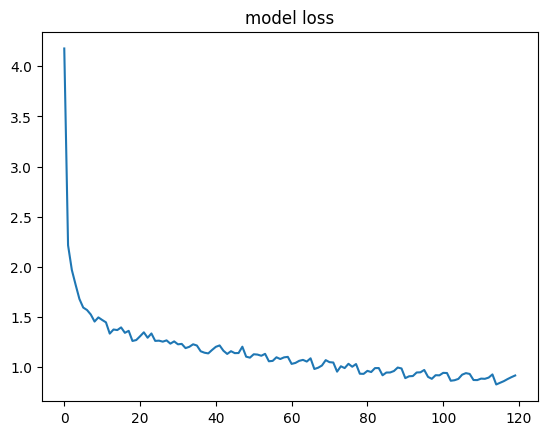

In [ ]:
# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

## Try the trained model

Let's try again to predict some characters given the input sentence 'ROMEO:'. Now the predicted characters should be much better.

In [ ]:
with torch.no_grad():
    input_str = 'ROMEO:'

    state = model.init_hidden(batch_size=1)
    state = state.to(device)
    data = torch.tensor([[ShakespeareDataset.char_to_index[char] for char in input_str]]).to(device)
    output, state = model(data, state)

    _, predicted_idxs = torch.max(output[0], dim = 1)
    predicted_idxs = predicted_idxs.cpu().numpy()

    predicted_str = ''.join([ShakespeareDataset.index_to_char[idx] for idx in predicted_idxs])

    print(f'Input shape: {data.size()}')
    print(f'Output shape: {data.size()}')
    print(f'Input string: {input_str}')
    print(f'Output string: {predicted_str}')

Input shape: torch.Size([1, 6])
Output shape: torch.Size([1, 6])
Input string: ROMEO:
Output string: DMEO:



## Generate new text

In [ ]:
def predict(dataset, model, text, next_chars=1000):
    model.eval()

    chars = [char for char in text]
    state = model.init_hidden(1)
    state = state.to(device)

    # we start by feeding all the input characters to our model
    x = torch.tensor([dataset.char_to_index[char] for char in chars])
    x = x.unsqueeze(0) # create a batch of 1
    x = x.to(device)

    for i in range(0, next_chars):

        y_pred, state = model(x, state)

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().cpu().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        chars.append(dataset.index_to_char[char_index])

        # the output of the model (a single character index) becomes the input at next iteration
        x = torch.tensor([[char_index]])
        x = x.to(device)

    return chars

predicted = predict(ShakespeareDataset, model,'ROMEO:')
print(''.join(predicted))

ROMEO:
Whitentless and most humble words to try;
For this right will with more such safeguards thee from his
As when for Edward's frosts and givest it there!

QUEEN ELIZABETH:
Padua be thus myself; I cannot go with quiet claim
Our cousin's death, which you do love hence with hath yet nobler.

KING EDWARD IV:
Then give me looks, I would not go return.

EXETER:
Harry, the duky disposition cleanless
Than thus.

MIRANDA:
O, no, sir! I am so for a feast;
Livious and joyful builders, waving: for it is
you fear it, for no mourning wooded in recessition
To hopeless throne. Sent between us bosom,
Fall becking impersant friar.

PRINCE EDWARD:
Nay, that is among that, my mother will not smooth
As the parcies remove of bloody knightly faultly.

MIRANDA:
There's a great patrician: yet beheld I see
thin in season. Was the foulest damned villain? we know
'Tis with the king exiled him to the proud with a sigh;
And may perforce mayst thou wash the writing rest,
And what we had too gentle thin away.
Tho

While some of the sentences are grammatically correct, most do not make sense. The model has not learned the meaning of words (we would need a much larger corpus for that, and probably a word level language model), but consider the following:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text. Now it does a pretty decent job on spelling.

* The structure of the output resembles a play, blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* The model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

# Homework

<span style="color:blue">
    
**Exercise 3:** Build two new models: one using Simple RNN cells (torch.nn.RNN) instead of GRUs(torch.nn.RNN), and the other using LSTMs (torch.nn.LSTM). Train all three models (GRU, LSTM, SimpleRNN) for 30 epochs and compare the loss curves. You can optionally try different configurations: embedding dimension, hidden layers dimensions, number of layers, etc.
    
</span>

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_dim,embedding_dim = embedding_dim)
        self.gru = nn.GRU(input_size = embedding_dim,num_layers = n_layers,hidden_size = hidden_dim,dropout = drop_prob, batch_first = True)
        self.fc = nn.Linear(in_features = hidden_dim, out_features = output_dim)


    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.gru(emb, h)
        out = self.fc(out)
        return out, h

    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

In [ ]:
input_dim = len(ShakespeareDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(ShakespeareDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

model = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model)

Model(
  (embedding): Embedding(65, 300)
  (gru): GRU(300, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


In [ ]:
num_epochs = 30

losses = train(train_loader, model, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.166955471038818}
{'epoch': 0, 'batch': 30, 'loss': 2.2454683780670166}
{'epoch': 0, 'batch': 60, 'loss': 1.9997349977493286}
{'epoch': 0, 'batch': 90, 'loss': 1.7906550168991089}
{'epoch': 0, 'batch': 120, 'loss': 1.6985331773757935}
{'epoch': 0, 'batch': 150, 'loss': 1.6581528186798096}
{'epoch': 1, 'batch': 0, 'loss': 1.5861245393753052}
{'epoch': 1, 'batch': 30, 'loss': 1.546278476715088}
{'epoch': 1, 'batch': 60, 'loss': 1.5254684686660767}
{'epoch': 1, 'batch': 90, 'loss': 1.4918781518936157}
{'epoch': 1, 'batch': 120, 'loss': 1.4220291376113892}
{'epoch': 1, 'batch': 150, 'loss': 1.4579435586929321}
{'epoch': 2, 'batch': 0, 'loss': 1.4160101413726807}
{'epoch': 2, 'batch': 30, 'loss': 1.3866095542907715}
{'epoch': 2, 'batch': 60, 'loss': 1.387518286705017}
{'epoch': 2, 'batch': 90, 'loss': 1.3691356182098389}
{'epoch': 2, 'batch': 120, 'loss': 1.3371423482894897}
{'epoch': 2, 'batch': 150, 'loss': 1.3474177122116089}
{'epoch': 3, 'batch': 0, 'lo

In [ ]:
# YOUR RESPONSE HERE
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(SimpleRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_dim,embedding_dim = embedding_dim)
        self.rnn = nn.RNN(input_size = embedding_dim,num_layers = n_layers,hidden_size = hidden_dim,dropout = drop_prob, batch_first = True)
        self.fc = nn.Linear(in_features = hidden_dim, out_features = output_dim)


    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.rnn(emb, h)
        out = self.fc(out)
        return out, h

    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

In [ ]:
input_dim = len(ShakespeareDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(ShakespeareDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

modelRNN = SimpleRNN(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(modelRNN)

SimpleRNN(
  (embedding): Embedding(65, 300)
  (rnn): RNN(300, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


In [ ]:
num_epochs = 30

lossesRNN = train(train_loader, modelRNN, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.164953708648682}
{'epoch': 0, 'batch': 30, 'loss': 2.218878746032715}
{'epoch': 0, 'batch': 60, 'loss': 1.9961864948272705}
{'epoch': 0, 'batch': 90, 'loss': 1.8792310953140259}
{'epoch': 0, 'batch': 120, 'loss': 1.8274325132369995}
{'epoch': 0, 'batch': 150, 'loss': 1.7474654912948608}
{'epoch': 1, 'batch': 0, 'loss': 1.6829663515090942}
{'epoch': 1, 'batch': 30, 'loss': 1.5972477197647095}
{'epoch': 1, 'batch': 60, 'loss': 1.6296603679656982}
{'epoch': 1, 'batch': 90, 'loss': 1.577197551727295}
{'epoch': 1, 'batch': 120, 'loss': 1.5686662197113037}
{'epoch': 1, 'batch': 150, 'loss': 1.5607632398605347}
{'epoch': 2, 'batch': 0, 'loss': 1.5337787866592407}
{'epoch': 2, 'batch': 30, 'loss': 1.5205836296081543}
{'epoch': 2, 'batch': 60, 'loss': 1.4940431118011475}
{'epoch': 2, 'batch': 90, 'loss': 1.5248664617538452}
{'epoch': 2, 'batch': 120, 'loss': 1.5231715440750122}
{'epoch': 2, 'batch': 150, 'loss': 1.4653899669647217}
{'epoch': 3, 'batch': 0, 'lo

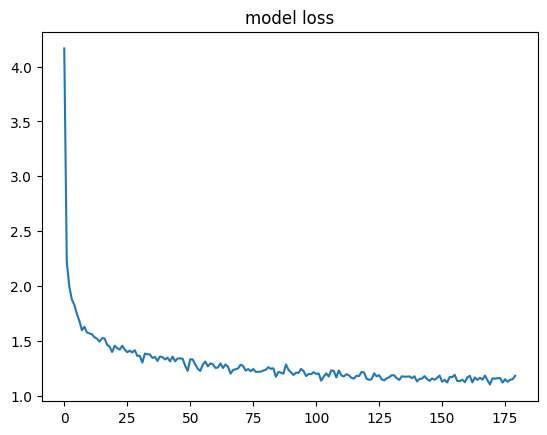

In [ ]:
plt.plot(lossesRNN)
plt.title('model loss')
plt.show()

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_dim,embedding_dim = embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim,num_layers = n_layers,hidden_size = hidden_dim,dropout = drop_prob, batch_first = True)
        self.fc = nn.Linear(in_features = hidden_dim, out_features = output_dim)


    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.lstm(emb, h)
        out = self.fc(out)
        return out, h

    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        #h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size)
        #c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size)
        #x, _ = self.BELT_LSTM(x, (h_0, c_0))
        h_0 = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        c_0 = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return (h_0,c_0)


In [ ]:
input_dim = len(ShakespeareDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(ShakespeareDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

modelLSTM = LSTM(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(modelLSTM)

LSTM(
  (embedding): Embedding(65, 300)
  (lstm): LSTM(300, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


In [ ]:
def trainLSTM(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion =  nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):

        for batch, (x, y) in enumerate(dataloader):
            state1,state2 = model.init_hidden(batch_size) # Start with a new state in each batch
            state1 = state1.to(device)
            state2 = state2.to(device)

            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            y_pred, (state1,state2) = model(x, (state1,state2))
            loss = criterion(y_pred.transpose(1, 2), y)

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
    return losses

In [ ]:
def predictLSTM(dataset, model, text, next_chars=1000):
    model.eval()

    chars = [char for char in text]

    state1,state2 = model.init_hidden(1)
    state1 = state1.to(device)
    state2 = state2.to(device)

    # we start by feeding all the input characters to our model
    x = torch.tensor([dataset.char_to_index[char] for char in chars])
    x = x.unsqueeze(0) # create a batch of 1
    x = x.to(device)

    for i in range(0, next_chars):

        y_pred, (state1,state2) = model(x, (state1,state2))

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().cpu().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        chars.append(dataset.index_to_char[char_index])

        # the output of the model (a single character index) becomes the input at next iteration
        x = torch.tensor([[char_index]])
        x = x.to(device)

    return chars


In [ ]:
num_epochs = 30

lossesLSTM = trainLSTM(train_loader, modelLSTM, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.171274662017822}
{'epoch': 0, 'batch': 30, 'loss': 2.3051390647888184}
{'epoch': 0, 'batch': 60, 'loss': 1.982683539390564}
{'epoch': 0, 'batch': 90, 'loss': 1.8146579265594482}
{'epoch': 0, 'batch': 120, 'loss': 1.7064714431762695}
{'epoch': 0, 'batch': 150, 'loss': 1.6099913120269775}
{'epoch': 1, 'batch': 0, 'loss': 1.5779335498809814}
{'epoch': 1, 'batch': 30, 'loss': 1.517198085784912}
{'epoch': 1, 'batch': 60, 'loss': 1.5076686143875122}
{'epoch': 1, 'batch': 90, 'loss': 1.441648244857788}
{'epoch': 1, 'batch': 120, 'loss': 1.509775996208191}
{'epoch': 1, 'batch': 150, 'loss': 1.3907536268234253}
{'epoch': 2, 'batch': 0, 'loss': 1.368766188621521}
{'epoch': 2, 'batch': 30, 'loss': 1.3515396118164062}
{'epoch': 2, 'batch': 60, 'loss': 1.3532594442367554}
{'epoch': 2, 'batch': 90, 'loss': 1.3575198650360107}
{'epoch': 2, 'batch': 120, 'loss': 1.3249162435531616}
{'epoch': 2, 'batch': 150, 'loss': 1.3251501321792603}
{'epoch': 3, 'batch': 0, 'loss'

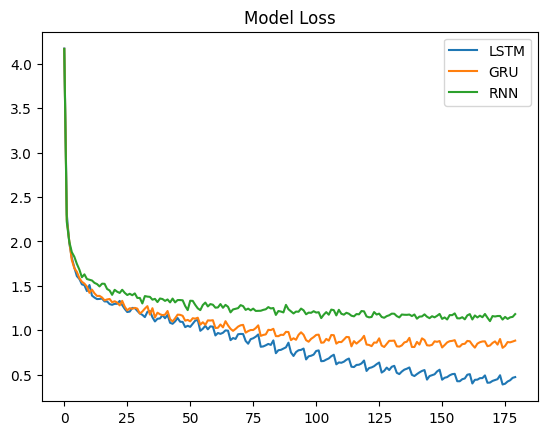

In [ ]:
plt.plot(lossesLSTM, label='LSTM')
plt.plot(losses, label='GRU')
plt.plot(lossesRNN, label='RNN')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
print("Results for the LSTM:")
predictedLSTM = predictLSTM(ShakespeareDataset, modelLSTM,'ROMEO:')
print(''.join(predictedLSTM))
print("----------------------------------------------------------------------------------------------")

Results for the LSTM:
ROMEO:
And I am lately king, command to him.

YORK:
Make an old woman, and he and I have done,
For your own issue will have all this,
Unless it be your title so much else
Than done to her.

LUCIO:
How say you what?

JULIET:
Ay, mine own brother: I am safely you out.

RUTES:
Why, how now, Grous!

CATESBY:
No, my good lord; it is more than I will unto.
O Warwick, Warwick! wert thou began to see his agon?
Ay, my Lord Hastings, when he stamp'd, indeed!

JOHN OF GAUNT:
Alas, the Duke of Lancaster has been made,
And give my just continually her sitting.

ISABELLA:
Can you content you, grave men, yet you are
the friar that you have, which lever lives.

KING RICHARD III:
Why, what with saints being dispatch'd for it!

MARIANA:
Be ready, sir, show our friends! how their profession sounds?
My title's heavy with a husband for his troop,
And yet my suit is neck and strange.
I am their mouths,
That can my wanton stands in him. Yet you
are amended to your country.

BRUTUS:
This

In [ ]:
#Try the trained models
print("Results for the GRU:")
predicted = predict(ShakespeareDataset, model,'ROMEO:')
print(''.join(predicted))
print("----------------------------------------------------------------------------------------------")

print("Results for the RNN:")
predictedRNN = predict(ShakespeareDataset, modelRNN,'ROMEO:')
print(''.join(predictedRNN))
print("----------------------------------------------------------------------------------------------")

print("Results for the LSTM:")
predictedLSTM = predictLSTM(ShakespeareDataset, modelLSTM,'ROMEO:')
print(''.join(predictedLSTM))
print("----------------------------------------------------------------------------------------------")

Results for the GRU:
ROMEO:
Sying, fellow! why, not like an officer.

PARIS:
Is my sorrow was born, with words, which not the second hath charged
With rapier and her prayers' soldiers; then surrently remain
And speeds me dreams, cut off the heats of wife:
Right swingly thanks, brave Gentleman, I pray, Pembler us,
Or, if love call Edward fright that princely father's brothers so,
Or else her pay have wrought his mind to prison,
Now in pain that stops me mine. You're wrong his custom: if you
can please you, sir, if you call do.
It is too rather fleed.

Second Citizen:
Our honour free at good, which Warwick's rabement?
Think you?

Both:
Your majesty of despite cold, hence; even from
her eyes shall make him stripe: the first degree is Grunio; and
Henry 'sight. Now, fellow, that victory is the noble;
All under nothing slightly heavenly person,
But though ever all my harms against Queen's spirit.
But have for your faith, he'll make bold each pitied
At a quart exElp the grief which I may;
Sub

We can see that the model with best performance is the LSTM one, because it have the lower loss value, and generate pretty large text with a good structure and real words. What wee can see is that much of the sentences make no sense



---



---



---



<span style="color:blue">

**Exercise 4:** Train your best model on a different dataset. Use the 'inaugural' corpus of the [NLTK](https://www.nltk.org/) library. Once trained generate some text with as we did for the model trained on the Shakespeare dataset. Compare the generated texts with both models using the smae "seed" (input) text. What differences do you appreciate? Why are they different?
    
</span>

The Natural Language Toolkit, or more commonly NLTK, is a suite of datasets, libraries and models for symbolic and statistical natural language processing (NLP). The Inaugural Address Corpus contains the US presidential inaugural addresses from 1789 to 2017. The following code loads the 'inaugural' corpus:

In [ ]:
import nltk
nltk.download('inaugural')

inaugural = nltk.corpus.inaugural
text = inaugural.raw()

print(f'Length of text: {len(text)} characters')

Length of text: 807276 characters


[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.


In [ ]:
class DatasetFromTextFile():
    def __init__(self, file1, sequence_length):
        self.file1 = file1
        self.sequence_length = sequence_length

        # The whole sequence of characters in the text file (including characters like the end of line character '\n', punctuation marks, etc.)
        self.chars = file1
        # The list of unique characters (our vocabulary)
        self.uniq_chars = self.get_uniq_chars()

        # A dictionary with indices as keys and characters as values
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        # A dictionary with characters as keys and indices as values
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        # The whole sequence of character indexes
        # We want to vectorize our text using one-hot vectors at character level
        # But instead of using the one-hot vector we just keep the index of the 1 value
        self.chars_indices = [self.char_to_index[w] for w in self.chars]

        # Split the sequence into chunks of `sequence_length` characters
        # `x` is the input to the model and `y` is the output of the model
        # `y` is the same seuqence as `x` but one character shifted to the right.
        self.x, self.y = self.get_data()

    def load_chars(self):
        with open(self.filename) as fp:
            text = fp.read()
        print(f'Length of text: {len(text)} characters')
        return text

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indices)-self.sequence_length, self.sequence_length):
            x.append(np.array(self.chars_indices[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indices[index+1:index+self.sequence_length+1]))

        return  torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y)).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        assert ((idx >= 0) & (idx < len(self.y))), "Dataset index out of range"
        return self.x[idx], self.y[idx]

In [ ]:
# YOUR RESPONSE HERE
# Create the dataset
sequence_length = 100
InauguralDataset = DatasetFromTextFile(text, sequence_length)

print(f'We have {InauguralDataset.x.shape[0]} input sequence samples of length {InauguralDataset.x.shape[1]} \
and {InauguralDataset.y.shape[0]} label sequences of length {InauguralDataset.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_loader_in = DataLoader(InauguralDataset, shuffle=True, batch_size=batch_size, drop_last=True)

Unique characters (vocabulary size): 85
We have 8072 input sequence samples of length 100 and 8072 label sequences of length 100


In [ ]:
input_dim = len(InauguralDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(InauguralDataset.uniq_chars)
n_layers = 4
drop_prob = 0.2

InauguralLSTM = LSTM(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(InauguralLSTM)

LSTM(
  (embedding): Embedding(85, 300)
  (lstm): LSTM(300, 1024, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=85, bias=True)
)


In [ ]:
num_epochs = 30

lossesGRU = trainLSTM(train_loader_in, InauguralLSTM, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.445428848266602}
{'epoch': 0, 'batch': 30, 'loss': 2.979534387588501}
{'epoch': 0, 'batch': 60, 'loss': 2.8585402965545654}
{'epoch': 0, 'batch': 90, 'loss': 2.4757399559020996}
{'epoch': 0, 'batch': 120, 'loss': 2.1114559173583984}
{'epoch': 1, 'batch': 0, 'loss': 2.1135237216949463}
{'epoch': 1, 'batch': 30, 'loss': 1.8491592407226562}
{'epoch': 1, 'batch': 60, 'loss': 1.6659061908721924}
{'epoch': 1, 'batch': 90, 'loss': 1.5731079578399658}
{'epoch': 1, 'batch': 120, 'loss': 1.5065182447433472}
{'epoch': 2, 'batch': 0, 'loss': 1.4519599676132202}
{'epoch': 2, 'batch': 30, 'loss': 1.4145634174346924}
{'epoch': 2, 'batch': 60, 'loss': 1.3496513366699219}
{'epoch': 2, 'batch': 90, 'loss': 1.3221306800842285}
{'epoch': 2, 'batch': 120, 'loss': 1.3216079473495483}
{'epoch': 3, 'batch': 0, 'loss': 1.2951300144195557}
{'epoch': 3, 'batch': 30, 'loss': 1.264535665512085}
{'epoch': 3, 'batch': 60, 'loss': 1.2479608058929443}
{'epoch': 3, 'batch': 90, 'loss'

In [ ]:
print("Results for the Inaugural GRU:")
predictedLSTM_in = predictLSTM(InauguralDataset, InauguralLSTM,'We need to reconstruct the country ')
print(''.join(predictedLSTM_in))
print("----------------------------------------------------------------------------------------------")
print("Results for the Romeo GRU:")
predictedLSTM_romeo = predictLSTM(ShakespeareDataset, modelLSTM,'We need to reconstruct the country ')
print(''.join(predictedLSTM_romeo))
print("----------------------------------------------------------------------------------------------")

Results for the Inaugural GRU:
We need to reconstruct the country which they have trusted.

In accordance with our institutions at the moment which has been the tranquillity of the cut of mankind.

This was the surest new wholesome success that fairness. We did the tempest of liberty, to build the passions under which we pursue not only the cost of an object of constitutional right, to the public expenditures government had formed, in many States, in disposition to force accountability of political and political rights. The man who has been adopted by no participation, but more devoting their consequences essentially from the true proportions of some. But exclusively under the guardianship and guidance of the distinction for the cost of industry, for the support of duty which in the discharge of power in the Capital of this government. When are many in any act of Nouth is of important guidance. It was certainly unspeated by the people, under the unmost predictions of the American time.

We can clearly see that the model trained with the inagural dataset create a decent output with a well structured speech . Instead in the model trained with Shakespeare dataset despite we start with the same seed word, the model creates a theather structure text, because this model is trained with an script theater datset